# Land Cover Classification of the TALANDCOVER Satellite Data With Semantic Segmentation

Author: **Marcin Sikorski**<br>
Date: February, 2026

### Introduction

Land use and land cover (LULC) classification using remote sensing data is a challenging problem that has evolved with the update and launch of new satellites in orbit. LUCL classification, generated from satellite imagery through semantic segmentation, has become fundamental for monitoring land changes. As new space satellites are launched with higher spatial and spectral resolution and shorter revisit times, LULC classification has evolved to take advantage of these improvements. However, these advancements also bring new challenges, such as the need for more sophisticated algorithms to process the increased volume and complexity of data. Deep learning techniques, especially convolutional neural networks (CNNs), show promising results in this area. Training deep learning models can be expensive, in terms of hardware and computational resources, and not accessible to everyone. They require complex architectures and algorithms for higher accuracies. In this notebook, a lightweight CNN based on the U-Net architecture is proposed to perform LULC classification over aerial images. Unlike heavier models such as DeepLabV3 or EfficientNet, Mobile-UNet has fewer parameters and therefore requires fewer computational resources to train it. We performed supervised semantic segmentation on an open dataset with diverse land cover. The analysis proved the model to be efficient in complex pixel-wise classification.

**Notebook Content:**
1. Preparing the Environment and Loading Data
2. Dataset Description
3. Implementing Spectral Indices
4. Class Weighting
5. Loss Function
6. Classification Validation and Evaluation Metrics
7. Deep Learnig Model Architecture and Training
8. Results and Discussion
9. Conclusions

### 1. Preparing the Environment and Loading Data

We begin by mounting Google Drive, importing the required libraries, and reading the dataset, which is provided as TIF files and loaded as NumPy arrays. Each satellite image has a corresponding label.

In [1]:
# mount G-Drive
from google.colab import drive
drive.mount('/content/drive')

# list content
#!pwd
#!ls /content/drive/MyDrive/

Mounted at /content/drive


In [ ]:
# CPU info (number of cores, architecture, etc.)
#!lscpu

In [2]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# paths to images & labels
BASE_DIR  = '/content/drive/MyDrive/'
IMAGE_DIR = BASE_DIR + 'Dataset_50/patch_images_128'
LABEL_DIR = BASE_DIR + 'Dataset_50/patch_labels_128'

# inputs
NUM_CLASSES = 6
IMG_SIZE = 128

def load_dataset(img_dir, lbl_dir):
    images = []
    labels = []
    for fname in os.listdir(img_dir):
        if fname.endswith('.tif'):
            img_path = os.path.join(img_dir, fname)
            lbl_path = os.path.join(lbl_dir, fname.replace('image', 'label'))

            with rasterio.open(img_path) as src_img, rasterio.open(lbl_path) as src_lbl:
                img = src_img.read().transpose(1, 2, 0)  # [h, w, b] (height, width, bands)
                lbl = src_lbl.read(1)  # [h, w]
                images.append(img)
                labels.append(lbl)

    return np.array(images), np.array(labels)

# collect images & masks
X, y = load_dataset(IMAGE_DIR, LABEL_DIR)

### 2. Dataset Description

The Tropical Andes Land Cover Dataset (TALANDCOVER) was built for the department of Antioquia Colombia and consists of three folders for the three types of sampling. To perform this segmentation task, we will use the sampling:

* balanced of minimum 50% coverage per class with 1389 images.

The proposed dataset is open and offers practical applications for understanding and addressing environmental challenges. It was obtained from NICFI satellite imagery. The aerial images are in true colors (RGB). More detailed description can be found [here](https://zenodo.org/records/8219553).

TALANDCOVER satellite imagery dataset details:

| Item                         | Description                        |
|------------------------------|------------------------------------|
| Application Field            | Satellite Image Segmentation       |
| Full Dataset Name            | Tropical Andes Land Cover Dataset  |
| Collection Year              | 2019                               |
| Number of Classes            | 6                                  |
| Type of Segmented Data       | Multiclass Mask                    |
| Image Format                 | TIF                                |
| Mask Format                  | TIF                                |
| Full Dataset Size            | 747.8 MB (ZIP)                     |
| Spatial Resolution           | 4.77 m per Pixel                   |
| Coordinate System            | EPSG:3857 - WGS 84/Pseudo-Mercator |
| Rows and Columns             | 128 x 128                          |
| Number of Images             | 1389 (Balanced 50%)                |
| Spatial Resolution of Images | R-G-B-NIR-SWIR                     |

Pixel values for label are:

| Label | Class                            |
|-------|----------------------------------|
| 0     | Bare-degraded lands              |
| 1     | Grasslands                       |
| 2     | Heterogeneous agricultural areas |
| 3     | Dense forest                     |
| 4     | Water bodies                     |
| 5     | Built-up areas                   |

In [3]:
tif_image = IMAGE_DIR + '/image_PNICFI_D2019-05_T598-1069_C0_N1147.tif'
tif_label = LABEL_DIR + '/label_PNICFI_D2019-05_T598-1069_C0_N1147.tif'

# read TIF image & get dimensions
with rasterio.open(tif_image) as src:
    height, width = src.height, src.width
    bands = src.count

# expecting five bands: [R, G, B, NIR, SWIR]
# CRS: WGS 84 / Pseudo-Mercator
print(f'Image shape: (bands: {bands}, height: {height}, width: {width})')
print(src.crs)
#print(src.crs.to_wkt())

with rasterio.open(tif_label) as src:
    height, width = src.height, src.width
    bands = src.count

print(f'Label shape: (bands: {bands}, height: {height}, width: {width})')

Image shape: (bands: 5, height: 128, width: 128)
EPSG:3857
Label shape: (bands: 1, height: 128, width: 128)


In [4]:
from matplotlib.colors import ListedColormap

# mapping: label value → hex color
CLASS_COLORS = {
    0: '#8c512f',     # brown
    1: '#7cc576',     # light green
    2: '#ffff8c',     # yellow
    3: '#006400',     # dark green
    4: '#0096ff',     # royal blue
    5: '#dc3232',     # red
}

# mapping: label value → name
CLASS_NAMES = {
    0: 'Bare-Degraded',
    1: 'Grassland',
    2: 'Agriculture',
    3: 'Forest',
    4: 'Water',
    5: 'Built-Up',
}

# create customize colormap
cus_cmap = ListedColormap([CLASS_COLORS[i] for i in range(len(CLASS_COLORS))])

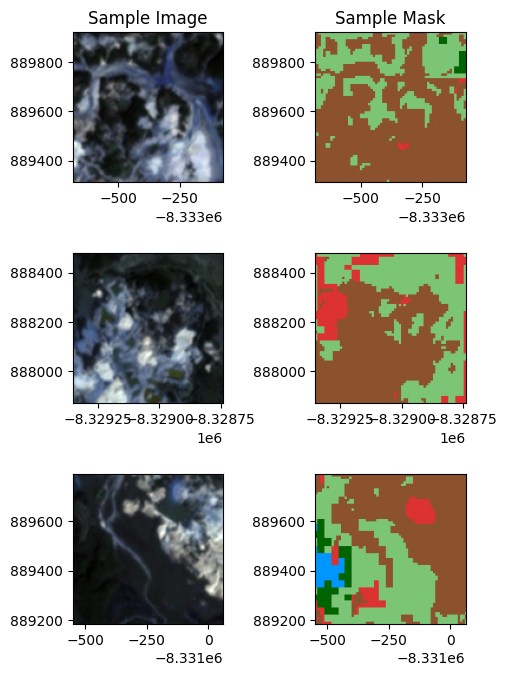

In [5]:
from rasterio.plot import show

# samples to display
samples = [
    (
        IMAGE_DIR + '/image_PNICFI_D2019-05_T598-1069_C0_N1147.tif',
        LABEL_DIR + '/label_PNICFI_D2019-05_T598-1069_C0_N1147.tif'
        ),
    (
        IMAGE_DIR + '/image_PNICFI_D2019-05_T598-1069_C0_N1220.tif',
        LABEL_DIR + '/label_PNICFI_D2019-05_T598-1069_C0_N1220.tif'
        ),
    (
        IMAGE_DIR + '/image_PNICFI_D2019-05_T598-1069_C0_N1060.tif',
        LABEL_DIR + '/label_PNICFI_D2019-05_T598-1069_C0_N1060.tif'
       ),
    ]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 7))

for row, (img_path, lbl_path) in enumerate(samples):

    with rasterio.open(img_path) as src_img:
        show(
            src_img.read([1, 2, 3]),
            ax=axes[row, 0],
            transform=src_img.transform,
            adjust=True,
            )
        #axes[row, 0].set_axis_off()

    with rasterio.open(lbl_path) as src_lbl:
        show(
            src_lbl.read(),
            ax=axes[row, 1],
            cmap=cus_cmap,
            transform=src_lbl.transform,
            adjust=True,
            )
        #axes[row, 1].set_axis_off()

    # set titles only on top row
    if row == 0:
        axes[row, 0].set_title('Sample Image')
        axes[row, 1].set_title('Sample Mask')

plt.tight_layout()
plt.show()

In [6]:
from prettytable import PrettyTable

# [h, w, bands] or [h, w]
total_pixels = y.size

unique_labels, counts = np.unique(y, return_counts=True)
percentages = counts / total_pixels * 100

# initialize table
table = PrettyTable(['Label', 'Class', 'Pixel Count', 'Proportion'])
table.align['Pixel Count'] = 'r'
table.align['Proportion'] = 'r'

for lbl, cnt, pct in zip(unique_labels, counts, percentages):
    name = CLASS_NAMES.get(lbl, f'Class {lbl} (unknown)')
    table.add_row([
        f'{lbl:>2}',
        name,
        f'{cnt:,}',
        f'{pct:5.2f}%',
    ])

# sort by coverage in descending order
table.sortby = 'Proportion'
table.reversesort = True

print('Class distribution in the training and validation data together:')
print(table)

Class distribution in the training and validation data together:
+-------+---------------+-------------+------------+
| Label |     Class     | Pixel Count | Proportion |
+-------+---------------+-------------+------------+
|    1  |   Grassland   |   5,435,827 |     23.89% |
|    3  |     Forest    |   4,939,585 |     21.71% |
|    2  |  Agriculture  |   4,594,505 |     20.19% |
|    5  |    Built-Up   |   2,737,035 |     12.03% |
|    4  |     Water     |   2,533,566 |     11.13% |
|    0  | Bare-Degraded |   2,516,858 |     11.06% |
+-------+---------------+-------------+------------+


The land cover is vegetation-heavy (almost 66%), not urban or coastal. Grasslands are almost the quarter of the entire mapped area. Forest and agricultural areas are also very prominent. These labels might be potentially most challenged to classify. Land degradation has the least distribution. Overall, the landscape seems to be mixed and variable. No single land cover overwhelmingly dominates. Top three labels are close (20-24%) and bottom three classes are also very close (11-12%) showing symmetric features for these two groups.

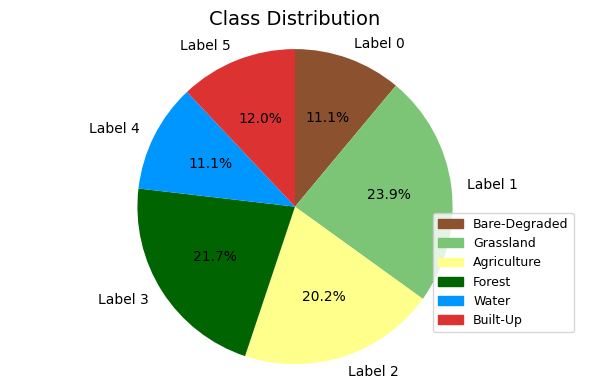

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 4))

# set pie chart
wedges, texts, autotexts = ax.pie(
    percentages,
    labels=[f'Label {lbl}' for lbl in unique_labels],
    autopct='%1.1f%%',
    #pctdistance=0.85,
    #wedgeprops=dict(width=0.5, edgecolor='w'),   # donut hole
    startangle=90,
    counterclock=False,
    colors=[CLASS_COLORS[i] for i in range(len(CLASS_COLORS))],
    #textprops={'color': 'orange'},
)

# equal aspect ratio ensures pie is circular
ax.axis('equal')
plt.title('Class Distribution', fontsize=14)

legend_patches = [
    mpatches.Patch(color=CLASS_COLORS[i], label=CLASS_NAMES[i])
    for i in CLASS_COLORS
]

# plot legend
ax.legend(handles=legend_patches,
          loc='upper right',
          bbox_to_anchor=(1, 0.5),
          fontsize=9,
          )

plt.tight_layout()
plt.show()

### 3. Implementing Spectral Indices

When performing LCLU classification with a deep learning model, adding spectral indices (derived features) can often improve accuracy — but need to be chosen with purpose. Spectral indices are mathematically-derived combinations of original bands designed to enhance and highlight specific surface properties (e.g., vegetation, water, soil). Instead of feeding the raw bands alone, indices give the model engineered signals representing meaningful biophysical distinctions. They can help deep models separate confusing classes (e.g., urban vs. bare soil, vegetation vs. water) by highlighting patterns that raw reflectances may not readily expose. This is a form of feature engineering. The new band combinations can enhance faster convergence and better generalization.

We will introduce these commonly used remote sensing indices:

| Index    | What it Highlights                          | Useful For                       |
|----------|---------------------------------------------|----------------------------------|
| **NDVI** | Vegetation greenness                        | Forest, grassland, crop areas    |
| **NDBI** | Built-up materials                          | Urban vs soil                    |
| **EVI**  | Vegetation with atmospheric/soil correction | Dense canopy, complex vegetation |
| **SAVI** | Reduces soil brightness influence           | Sparse vegetation, arid areas    |
| **NDWI** | Water emphasis                              | Water bodies vs vegetation/soil  |

Formulas:

Normalized Difference Vegetation Index:
$$NDVI = \frac{NIR - Red}{NIR + Red}$$

Normalized Difference Built-Up Index:
$$NDBI = \frac{SWIR - NIR}{SWIR + NIR}$$

Enhanced Vegetation Index:
$$EVI = \frac{NIR - Red}{NIR + 6 \cdot Red - 7.5 \cdot Blue + 1}$$

Soil Adjusted Vegetation Index (with $L = 0.5$):
$$SAVI = \frac{(NIR - Red)}{(NIR + Red + L)}(1 + L)$$

Normalized Difference Water Index:
$$NDWI = \frac{Green - NIR}{Green + NIR}$$

In [7]:
def compute_ndvi(nir, red, eps=1e-6):
    return (nir - red) / (nir + red + eps)

def compute_ndbi(swir, nir, eps=1e-6):
    return (swir - nir) / (swir + nir + eps)

def compute_evi(nir, red, blue, eps=1e-6):
    return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0 + eps)

def compute_savi(nir, red, L=0.5, eps=1e-6):
    return ((nir - red) / (nir + red + L + eps)) * (1.0 + L)

def compute_ndwi(green, nir, eps=1e-6):
    return (green - nir) / (green + nir + eps)


def add_spectral_indices(X):
    """
    Parameters
    ----------
    X : np.ndarray
        Shape: (n, h, w, b)

    Assumed band order:
        0: Red
        1: Green
        2: Blue
        3: NIR
        4: SWIR

    Returns
    -------
    X_aug : np.ndarray
        Shape: (n, h, w, b + 5)
        Added bands/channels:
            NDVI, NDBI, EVI, SAVI, NDWI
    """

    # extract bands
    red   = X[..., 0]
    green = X[..., 1]
    blue  = X[..., 2]
    nir   = X[..., 3]
    swir  = X[..., 4]

    # compute indices
    ndvi = compute_ndvi(nir, red)
    ndbi = compute_ndbi(swir, nir)
    evi  = compute_evi(nir, red, blue)
    savi = compute_savi(nir, red)
    ndwi = compute_ndwi(green, nir)

    # expand dims to channels
    indices = [ndvi, ndbi, evi, savi, ndwi]
    indices = [idx[..., np.newaxis] for idx in indices]

    # concatenate & normalize per channel
    X_aug = np.concatenate([X] + indices, axis=-1)
    X_aug = (X_aug - X_aug.mean(axis=(0, 1, 2))) / X_aug.std(axis=(0, 1, 2))

    return X_aug

In this step, the channels will be normalized and the data will be partitioned into training and validation sets with a 80:20 ratio. Final data preparations will be performed by converting NumPy labels into one-hot tensors.

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# normalize original bands first
X = X.astype(np.float32)
X /= 255.0

# add NDVI, NDBI, EVI, SAVI, NDWI
X = add_spectral_indices(X)

# keep labels as NumPy first
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# train / val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    )

print(f'Unique labels: {np.unique(y_train)}')

# one-hot encode labels
y_train = tf.one_hot(y_train, NUM_CLASSES)
y_val = tf.one_hot(y_val, NUM_CLASSES)

# [n, h, w, b]
# bands: [R, G, B, NIR, SWIR, NDVI, NDBI, EVI, SAVI, NDWI]
print(f'Train images: {X_train.shape}')
print(f'Train masks:  {y_train.shape}')
print(f'\nValidation images: {X_val.shape}')
print(f'Validation masks:  {y_val.shape}')

Unique labels: [0 1 2 3 4 5]
Train images: (1111, 128, 128, 10)
Train masks:  (1111, 128, 128, 6)

Validation images: (278, 128, 128, 10)
Validation masks:  (278, 128, 128, 6)


### 4. Class Weighting

We will compute class frequencies from masks to address class imbalance for our imagery. We want to prevent the model from favoring classes. Land cover datasets almost always dominant with vegetation labels and less with urban regions or water. Class weights compensate for underrepresented classes by increasing their contribution to the loss function. Without weighting, frequent classes can dominate training, leading to biased predictions toward those classes. Weighting enhances overall generalization and stabilizes training, improving numerical stability and convergence, and preventing excessively large gradients.

In [9]:
def compute_class_weights(y, num_classes):
    """
    y: one-hot encoded labels [n, h, w, b]
    """
    y_flat = np.argmax(y, axis=-1).flatten()

    class_counts = np.bincount(y_flat, minlength=num_classes)
    total = np.sum(class_counts)

    # inverse frequency weighting
    class_weights = total / (num_classes * class_counts + 1e-6)

    return class_weights

class_weights = compute_class_weights(y_train, NUM_CLASSES)

print(f'Class weights: {class_weights}')

Class weights: [1.51237769 0.71539418 0.83942725 0.75225891 1.42465663 1.39194887]


These weights seem to have moderate and not extreme values. They should be very reasonable to use. Classes 1 and 2 are down-weighted relative to most other classes due to their dominance in frequency. Smaller weights will make the model penalize them making mistakes on labels.

We will modify and increase weights for labels 1 and 2 — Grasslands and Agricultural areas. Both are very similar and can cause semantic issues during training. Boosting weights for similar or easily confused classes helps the model better distinguish subtle differences between them.

In [10]:
# boost weights for classes 1 & 2
class_weights[1] *= 2.0
class_weights[2] *= 2.0
CLASS_WEIGHTS = np.clip(class_weights, 0.9, 1.6)

### 5. Loss Function


A composite loss function integrating class weighting, focal loss, and a class-specific Tversky term was used to mitigate class imbalance and reduce semantic confusion between similar vegetation classes. This formulation improves minority-class learning while enhancing boundary delineation for spectrally overlapping land-cover types. The loss function will include the following components:
1. Weighted Categorical Cross-Entropy (WCE)

$$
\mathcal{L}_{\text{WCE}} = \mathbb{E}\left[
w_c \cdot \left( - \sum_{c=1}^{C} y_c \log(\hat{y}_c) \right)
\right]
$$

where $w_c$ is the class weight for class $c$. This is standard categorical cross-entropy, but each pixel's loss is scaled by the weight of its true class. This increases the influence of underrepresented or critical classes during training and mitigates class imbalance.

2. Categorical Focal Loss

$$
\mathcal{L}_{\text{Focal}}
= \mathbb{E}\left[
\sum_{c=1}^{C}
\alpha , (1 - \hat{y}_c)^{\gamma}
\left( - y_c \log(\hat{y}_c) \right)
\right]
$$

Focal loss down-weights well-classified pixels and focuses learning on hard or misclassified examples. The parameter $\gamma$ controls how strongly easy samples are suppressed.

3. Dice Loss

$$
\mathcal{L}_{\text{Dice}}
= 1 - \frac{2 \lvert Y \cap \hat{Y} \rvert + \epsilon}
{\lvert Y \rvert + \lvert \hat{Y} \rvert + \epsilon}
$$

Dice loss directly optimizes spatial overlap between predictions and ground truth, making it well suited for segmentation tasks with imbalanced foreground-background distributions. $\epsilon$ is the smoothing parameter, a tiny constant added to both the numerator and denominator to ensure numerical stability and to prevent division by zero.

4. Tversky Loss (Classes 1 & 2)

$$
\mathcal{L}_{\text{Tversky}}
= 1 -
\frac{TP + \epsilon}
{TP + \alpha FP + \beta FN + \epsilon}
$$

Tversky loss generalizes Dice loss by allowing asymmetric penalization of false positives and false negatives. Applying it only to classes 1 and 2 explicitly targets semantic confusion between these visually similar classes. $\alpha$ and $\beta$ are weights and at the same time the function's hyperparameters.

5. Final Combined Loss

$$
\mathcal{L}_{\text{total}}
= 0.5 \mathcal{L}_{\text{WCE}}
+ 0.5 \mathcal{L}_{\text{Focal}}
+ 0.3 \mathcal{L}_{\text{Tversky}}^{(1,2)}
$$

Finally, the loss function combines class-balanced supervision (WCE), hard-sample emphasis (focal), and class-specific boundary refinement (Tversky). This design improves robustness to class imbalance while explicitly enhancing discrimination between spectrally similar vegetation classes.

In [11]:
# categorical cross-entropy with weights
def weighted_categorical_crossentropy(class_weights):
    # class weights as a tensor
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(weights * ce)

    return loss

# categorical focal loss
def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * ce, axis=-1))

    return loss

# Dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - tf.reduce_mean(dice)

# Tversky loss for classes 1 & 2
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2])

    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

    return 1.0 - tf.reduce_mean(tversky)

def class_12_tversky(y_true, y_pred):
    return tversky_loss(
        y_true[..., 1:3],
        y_pred[..., 1:3],
        alpha=0.8,          # other weight configuration to try
        beta=0.2,           # alpha=0.7, beta=0.3
        )

# combine all loss functions
def full_loss(class_weights, alpha=0.5, gamma=2.5):
    wce = weighted_categorical_crossentropy(class_weights)
    focal = categorical_focal_loss(alpha, gamma)

    def loss(y_true, y_pred):
        base = 0.5 * wce(y_true, y_pred) + 0.5 * focal(y_true, y_pred)
        tv   = class_12_tversky(y_true, y_pred)

        return base + 0.3 * tv

    return loss

### 6. Classification Validation and Evaluation Metrics

In order to evaluate the performance of the proposed land cover classification model, several metrics will be used. Considering land cover classification as a highly imbalanced problem, it is important to use metrics that can handle the class imbalance effectively.

The F1 score (or Dice) is used as the primary metric for evaluating the model's performance, especially for multi-class tasks. The F1 score is a measure of the balance between precision and recall, and it provides a single metric that combines both of these important aspects into a single value. Another basic metric for semenatic segmentation is intersection over union (IoU) also used to assess the model's performance. It quantifies the precision of a segmentation algorithm by overlapping the predictions made by the model with the ground truth. Cohen's kappa is robust and relevant in segmentation (pixel-level labeling) and also will be introduced. It measures how much agreement there is between two labelers (or a model and ground truth) after accounting for agreement that would happen just by chance.

$$mPrecision = \frac{1}{N} \sum_{i=1}^N \frac{TP_i}{TP_i + FP_i}$$

$$mRecall = \frac{1}{N} \sum_{i=1}^N \frac{TP_i}{TP_i + FN_i}$$

$$mF1 = \frac{1}{N} \sum_{i=1}^N \frac{2 \times Precision_i \times Recall_i}{Precision_i + Recall_i}$$

$$mIoU = \frac{1}{N} \sum_{i=1}^N \frac{TP_i}{TP_i + FP_i + FN_i}$$

$$m\kappa = \frac{1}{N} \sum_{i=1}^N \frac{2 (TP_i \times TN_i - FN_i \times FP_i)}{(TP_i + FP_i)(FP_i + TN_i) + (TP_i + FN_i)(FN_i + TN_i)}$$

Precision measures the proportion of true positive predictions out of all positive predictions, while recall measures the proportion of true positive predictions out of all actual positive cases.

| Concept       | What it Answers?                                       | Depends on IoU? |
|---------------|--------------------------------------------------------|-----------------|
| **Precision** | How precise (trustworthy) are the detections?          | Yes             |
| **Recall**    | How complete are the detections (how many are missed)? | Yes             |
| **F1**        | Harmonic mean (balance) between precision & recall     | Yes             |
| **IoU**       | How well does the box localize the object?             | —               |
| **Cohen's κ** | How much agreement exists beyond chance, accounting for class imbalance? | No             |

These presented performance metrics (except Cohen's kappa) will be computed for each class across every epoch and then a mean over the number of classes will be taken.

In [12]:
# precision
class MeanPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.precisions = self.add_weight(
            shape=(num_classes,), initializer='zeros'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            tp = tf.reduce_sum(
                tf.cast((y_true == c) & (y_pred == c), tf.float32)
            )
            fp = tf.reduce_sum(
                tf.cast((y_true != c) & (y_pred == c), tf.float32)
            )
            self.precisions[c].assign(
                tf.math.divide_no_nan(tp, tp + fp)
            )

    def result(self):
        return tf.reduce_mean(self.precisions)

    def reset_states(self):
        self.precisions.assign(tf.zeros_like(self.precisions))

In [13]:
# recall
class MeanRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.recalls = self.add_weight(
            shape=(num_classes,), initializer='zeros'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            tp = tf.reduce_sum(
                tf.cast((y_true == c) & (y_pred == c), tf.float32)
            )
            fn = tf.reduce_sum(
                tf.cast((y_true == c) & (y_pred != c), tf.float32)
            )
            self.recalls[c].assign(
                tf.math.divide_no_nan(tp, tp + fn)
            )

    def result(self):
        return tf.reduce_mean(self.recalls)

    def reset_states(self):
        self.recalls.assign(tf.zeros_like(self.recalls))

In [14]:
# F1 score (Dice)
class MeanF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_f1', ignore_background=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.ignore_background = ignore_background

        self.tp = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros'
        )
        self.fp = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros'
        )
        self.fn = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # convert one-hot → labels
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            true_c = tf.equal(y_true, c)
            pred_c = tf.equal(y_pred, c)

            tp = tf.reduce_sum(tf.cast(true_c & pred_c, tf.float32))
            fp = tf.reduce_sum(tf.cast(~true_c & pred_c, tf.float32))
            fn = tf.reduce_sum(tf.cast(true_c & ~pred_c, tf.float32))

            self.tp.assign_add(tf.one_hot(c, self.num_classes) * tp)
            self.fp.assign_add(tf.one_hot(c, self.num_classes) * fp)
            self.fn.assign_add(tf.one_hot(c, self.num_classes) * fn)

    def result(self):
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)

        f1 = tf.math.divide_no_nan(
            2 * precision * recall,
            precision + recall
        )

        return tf.reduce_mean(f1)

    def reset_states(self):
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

In [15]:
# intersection over union
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

        self.intersections = self.add_weight(
            name='intersections',
            shape=(num_classes,),
            initializer='zeros',
        )
        self.unions = self.add_weight(
            name='unions',
            shape=(num_classes,),
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # convert one-hot → labels
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            true_c = tf.equal(y_true, c)
            pred_c = tf.equal(y_pred, c)

            intersection = tf.reduce_sum(
                tf.cast(true_c & pred_c, tf.float32)
            )
            union = tf.reduce_sum(
                tf.cast(true_c | pred_c, tf.float32)
            )

            # update whole vector safely
            self.intersections.assign_add(
                tf.one_hot(c, self.num_classes) * intersection
            )
            self.unions.assign_add(
                tf.one_hot(c, self.num_classes) * union
            )

    def result(self):
        iou = tf.math.divide_no_nan(self.intersections, self.unions)
        return tf.reduce_mean(iou)

    def reset_states(self):
        self.intersections.assign(tf.zeros_like(self.intersections))
        self.unions.assign(tf.zeros_like(self.unions))

In [ ]:
"""
# optional: IoU separately for each class
class PerClassIoU(tf.keras.metrics.Metric):
    def __init__(self, class_id, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.class_id = class_id
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        true_c = tf.equal(y_true, self.class_id)
        pred_c = tf.equal(y_pred, self.class_id)

        intersection = tf.reduce_sum(
            tf.cast(true_c & pred_c, tf.float32)
        )
        union = tf.reduce_sum(
            tf.cast(true_c | pred_c, tf.float32)
        )

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return tf.math.divide_no_nan(self.intersection, self.union)

    def reset_states(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

CLASS_NAMES = [
    'Bare-Degraded',
    'Grassland',
    'Agriculture',
    'Forest',
    'Water',
    'Built-Up',
    ]

iou_metrics = [
    PerClassIoU(i, name=f'IoU_{CLASS_NAMES[i]}')
    for i in range(NUM_CLASSES)
]
"""

### 7. Deep Learnig Model Architecture and Training

For this multiclass semantic segmentation task, we will use a lightweight U-Net-based architecture, termed Mobile-UNet. The network employs depthwise-separable convolutions to reduce computational complexity while preserving representational capacity. An encoder-decoder structure with skip connections enables multi-scale feature learning and accurate spatial localization.

The encoder progressively downsamples feature maps while increasing channel depth (32-256 filters), capturing contextual information at multiple scales. A bottleneck block provides a compact latent representation, which is then upsampled in the decoder using nearest-neighbor upsampling and feature concatenation from corresponding encoder layers. Batch normalization and ReLU activations are applied after each convolution to improve training stability. The network outputs per-pixel class probabilities via a 1x1 convolution followed by a softmax activation, enabling multiclass segmentation. The performance of the proposed model will be evaluated with previously defined metrics and training dataset.

In [ ]:
from tensorflow.keras import layers, models

# depthwise-separable convolutions
def ds_conv_block(x, filters):
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

# define segmentation model's architecture
def MobileUNet(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # encoder
    c1 = ds_conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = ds_conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = ds_conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    # bottleneck
    b = ds_conv_block(p3, 256)

    # decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = ds_conv_block(u3, 128)
    #c4 = layers.SpatialDropout2D(0.2)(c4)   # optional regularization

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = ds_conv_block(u2, 64)
    #c5 = layers.SpatialDropout2D(0.2)(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = ds_conv_block(u1, 32)
    #c6 = layers.SpatialDropout2D(0.2)(c6)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c6)

    return models.Model(inputs, outputs, name='Mobile-UNet')

# sequential model
model = MobileUNet(
    input_shape=(IMG_SIZE, IMG_SIZE, X.shape[-1]),
    num_classes=NUM_CLASSES,
)

# display Mobile-UNet architecture
#model.summary()

In [18]:
# quick property check
print(f'Input shape:  {model.input_shape}')
print(f'Output shape: {model.output_shape}')
print(f'Number of layers: {len(model.layers)}')

Input shape:  (None, 128, 128, 10)
Output shape: (None, 128, 128, 6)
Number of layers: 53


We will set the Adam function as the model's optimizer. This is a good default choice and works well with large datasets and complex models. It combines the momentum and RMSprop techniques to provide a more balanced and memory efficient optimization process. Additionally, it adapts the learning rate for each parameter automatically.

General parameters list for the training process:

| Parameter                      | Value                               |
|--------------------------------|-------------------------------------|
| Batch Size                     | 16                                  |
| Epochs                         | 50                                  |
| Optimization Function          | Adam (Adaptive Moment Optimization) |
| Beta_1                         | 0.9                                 |
| Beta_2                         | 0.999                               |
| Epsilon                        | $1 \times 10^{-7}$                  |
| Initial Learning Rate          | $1 \times 3^{-4}$                   |
| Loss Function                  | WCE + Focal + Dice + Tversky        |
| Tversky Loss Weights           | alpha=0.8, beta=0.2                 |
| Categorical Focal Loss Weights | alpha=0.5, gamma=2.5                |
| Reguralization Method          | Batch Normalization                 |
| Activation Function            | Softmax                             |

In [ ]:
# define Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    name='adam',
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    )

# final combined loss function
loss_func = full_loss(
    class_weights=CLASS_WEIGHTS,
    alpha=0.5,
    gamma=2.5,
    )

model.compile(
    optimizer=adam_optimizer,
    loss=loss_func,
    metrics=[
        #'accuracy',
        MeanPrecision(NUM_CLASSES),
        MeanRecall(NUM_CLASSES),
        MeanF1(NUM_CLASSES),
        MeanIoU(NUM_CLASSES),
    ],
    )

Two callbacks will be implemented:
* `BackupAndRestore`: Recovers training from an interruption that has happened in the middle of training execution, by backing up the training states in a temporary checkpoint file, at the end of each epoch. Each backup overwrites the previously written checkpoint file, so at any given time there is at most one such checkpoint file for backup/restoring purpose.
* `ReduceLROnPlateau`: Reduces learning rate when a metric has stopped improving. It will monitor mIoU for validation dataset. The factor will reduce the learning rate by 0.3 if no improvement happens after 5 epochs. The max mode ensures the learning rate will be reduced when the quantity monitored has stopped increasing.

Finally, we will run the fitting execution for Mobile-UNet and export the model with its computed and updated weights.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, BackupAndRestore

# learning rate schedule
reduce_lr = ReduceLROnPlateau(
    monitor='val_mean_iou',
    factor=0.3,
    patience=5,     # or 3
    verbose=0,
    mode='max',
)

# backup callback
backup_path = BASE_DIR + 'tf_backups'
backup_cb = tf.keras.callbacks.BackupAndRestore(
    backup_dir=backup_path,
    save_freq='epoch',
)

# train Mobile-UNet
mod_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    epochs=50,
    batch_size=16,
    callbacks=[reduce_lr, backup_cb],
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - loss: 1.5831 - mean_f1: 0.3466 - mean_iou: 0.2202 - mean_precision: 0.5045 - mean_recall: 0.4838 - val_loss: 1.7396 - val_mean_f1: 0.0590 - val_mean_iou: 0.0359 - val_mean_precision: 0.0597 - val_mean_recall: 0.1667 - learning_rate: 3.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - loss: 1.1141 - mean_f1: 0.6276 - mean_iou: 0.4691 - mean_precision: 0.6443 - mean_recall: 0.6589 - val_loss: 1.7141 - val_mean_f1: 0.0591 - val_mean_iou: 0.0359 - val_mean_precision: 0.0597 - val_mean_recall: 0.1667 - learning_rate: 3.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - loss: 0.9996 - mean_f1: 0.6738 - mean_iou: 0.5225 - mean_precision: 0.6555 - mean_recall: 0.6779 - val_loss: 1.6753 - val_mean_f1: 0.0591 - val_mean_iou: 0.0359 - val_mean_precision: 0.1153 - val_mean_recall: 0.1667 - learning_rate: 3.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 350s 5s/step - loss: 0.9328 - mean_f1: 0.6935 - mean_iou: 0.5434 - mean

In [ ]:
# export model to serialized file
#model_path = BASE_DIR + 'mob_unet_data/mobile_unet.h5'
model_path = BASE_DIR + 'mob_unet_data/mobile_unet.keras'
model.save(model_path)

In [ ]:
import pandas as pd

# convert training history to DataFrame
results = pd.DataFrame(mod_history.history)

results_path = os.path.join(BASE_DIR, 'mob_unet_data/mobile_unet_history.csv')

# append to CSV, write header only if file doesn't exist
results.to_csv(
    results_path,
    mode='a',
    header=not os.path.exists(results_path),
    index=False,
)

# re-load all training history - new & existing
df_results = pd.read_csv(BASE_DIR + 'mob_unet_data/mobile_unet_history.csv')
df_results.round(4).tail(10)

,loss,mean_f1,mean_iou,mean_precision,mean_recall,val_loss,val_mean_f1,val_mean_iou,val_mean_precision,val_mean_recall,learning_rate
40,0.7142,0.7740,0.6455,0.6575,0.7292,0.7606,0.7555,0.6168,0.6287,0.5964,0.0
41,0.7257,0.7693,0.6388,0.4797,0.4790,0.7607,0.7556,0.6170,0.6290,0.5992,0.0
42,0.7249,0.7695,0.6399,0.6321,0.6264,0.7599,0.7557,0.6171,0.6289,0.5967,0.0
43,0.7127,0.7733,0.6451,0.6301,0.7107,0.7591,0.7559,0.6173,0.6295,0.5954,0.0
44,0.7178,0.7704,0.6407,0.7584,0.7812,0.7586,0.7560,0.6173,0.6296,0.5950,0.0
45,0.7250,0.7680,0.6384,0.6211,0.6576,0.7592,0.7559,0.6172,0.6300,0.5954,0.0
46,0.7140,0.7739,0.6457,0.6645,0.7019,0.7592,0.7558,0.6171,0.6299,0.5949,0.0
47,0.7221,0.7704,0.6406,0.5948,0.6350,0.7601,0.7557,0.6170,0.6293,0.5966,0.0
48,0.7136,0.7744,0.6461,0.6663,0.6892,0.7598,0.7557,0.6171,0.6296,0.5968,0.0
49,0.7113,0.7734,0.6458,0.7257,0.7693,0.7594,0.7559,0.6172,0.6296,0.5961,0.0


### 8. Results and Discussion

We will evaluate the neural network's performance using several approaches, including analysis of learning curves, evaluation metrics, and the confusion matrix. Metrics such as IoU, F1-score, and Cohen's kappa will be compared across classes.

The results will be examined to identify patterns, strengths, and weaknesses of the trained model.

In [ ]:
# extract change epochs for learning rate
lr = df_results['learning_rate']

# boolean mask where learning rate changes
lr_change_mask = lr.ne(lr.shift())

# indices (or epochs) where learning rate changes
lr_change_epochs = df_results.index[lr_change_mask].tolist()

# drop first element with zero
del lr_change_epochs[0]

lr_change_epochs

[23, 29, 34, 39, 44, 49]

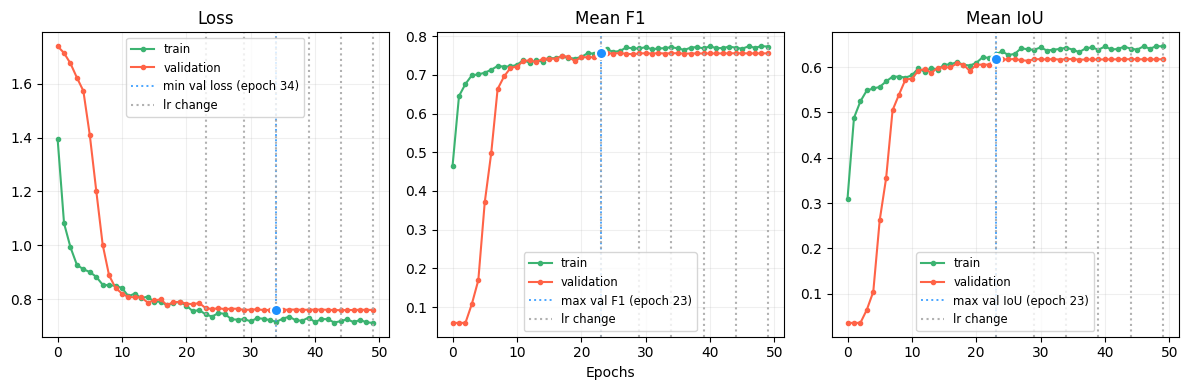

In [ ]:
# plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

#epochs = range(1, len(df_results) + 1)

# line propeties
train_props = {'color': 'mediumseagreen', 'marker': '.', 'label': 'train'}
val_props   = {'color': 'tomato', 'marker': '.', 'label': 'validation'}

# vertical lines & marker properties
epoch_props = {
    'color': 'dodgerblue',
    'linestyle': ':',
    'alpha': 0.8,
    'linewidth': 1.4,
    }

marker_props = {
    'marker': 'o',
    'color': 'dodgerblue',
    'markersize': 8,
    'markeredgecolor': 'white',
    'markeredgewidth': 1.5,
    'zorder': 10,
    }

lr_props = {'color': 'darkgray', 'linestyle': ':', 'alpha': 0.9}

# 1. loss plot
ax1.plot(df_results['loss'], **train_props)
ax1.plot(df_results['val_loss'], **val_props)

best_epoch = df_results['val_loss'].idxmin()    # epochs numbered from 0, not 1
best_loss  = df_results[f'val_loss'].min()

ax1.axvline(x=best_epoch,
            label=f'min val loss (epoch {best_epoch})',
            **epoch_props,
            )

ax1.plot(best_epoch, best_loss, **marker_props)

for i, e in enumerate(lr_change_epochs):
    ax1.axvline(
        e,
        label='lr change' if i == 0 else '_nolegend_',
        **lr_props,
        )

ax1.set_title('Loss')
ax1.legend(fontsize='small')
ax1.grid(alpha=0.2)

# 2. F1 plot
ax2.plot(df_results['mean_f1'], **train_props)
ax2.plot(df_results['val_mean_f1'], **val_props)

best_epoch = df_results['val_mean_f1'].idxmax()
best_f1    = df_results[f'val_mean_f1'].max()

ax2.axvline(x=best_epoch,
            label=f'max val F1 (epoch {best_epoch})',
            **epoch_props,
            )

ax2.plot(best_epoch, best_f1, **marker_props)

for i, e in enumerate(lr_change_epochs):
    ax2.axvline(
        e,
        label='lr change' if i == 0 else '_nolegend_',
        **lr_props,
        )

ax2.set_xlabel('Epochs')
ax2.set_title('Mean F1')
ax2.legend(fontsize='small')
ax2.grid(alpha=0.2)

# 3. IoU plot
ax3.plot(df_results['mean_iou'], **train_props)
ax3.plot(df_results['val_mean_iou'], **val_props)

best_epoch = df_results['val_mean_iou'].idxmax()
best_iou   = df_results[f'val_mean_iou'].max()

ax3.axvline(x=best_epoch,
            label=f'max val IoU (epoch {best_epoch})',
            **epoch_props,
            )

ax3.plot(best_epoch, best_iou, **marker_props)

for i, e in enumerate(lr_change_epochs):
    ax3.axvline(
        e,
        label='lr change' if i == 0 else '_nolegend_',
        **lr_props,
        )

ax3.set_title('Mean IoU')
ax3.legend(fontsize='small')
ax3.grid(alpha=0.2)

plt.tight_layout()
plt.show()

Learning curves display the learning dynamics and insights. Overall, this is a correct and balanced training run. There are no visible leakages or optimizer issues. Here are some key impressions:
* **clean and gradual convergence:** training and validation curves track each other well after the initial warm-up;
* **no serious overfitting:** gap between train and validation F1/IoU is small and acceptable;
* **learning rate schedule is doing as expected:** each learning rate drop gives a small but real improvement / stabilization.

The model generalizes very well, is not memorizing tiles, and is well-tuned. Regularization is working correctly. Any remaining errors are semantic, not optimization-related or technical. We can notice the learning rate fluently and periodically drops throughout the fitting process. Overall, this is a solid baseline Mobile-UNet, probably near its ceiling for this label setup.

In [ ]:
from tensorflow.keras.metrics import Accuracy

# evaluate Mobile-UNet on val dataset & display metrics
# predictions
y_pred = model.predict(X_val, verbose=1, batch_size=16)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_val, axis=-1)

# confusion matrix
conf_mat = tf.math.confusion_matrix(
    y_true_labels.flatten(),
    y_pred_labels.flatten(),
    num_classes=NUM_CLASSES,
).numpy()

# initialize metric containers
iou_per_class = np.zeros(NUM_CLASSES)
precision_per_class = np.zeros(NUM_CLASSES)
recall_per_class = np.zeros(NUM_CLASSES)
f1_per_class = np.zeros(NUM_CLASSES)
kappa_per_class = np.zeros(NUM_CLASSES)

tp_all = np.zeros(NUM_CLASSES)
fp_all = np.zeros(NUM_CLASSES)
fn_all = np.zeros(NUM_CLASSES)
tn_all = np.zeros(NUM_CLASSES)

# function for Cohen's kappa
def cohens_kappa_per_class(conf_mat):
    """
    One-vs-rest Cohen's kappa for each class.
    conf_mat: (K, K) numpy array
    returns: (K,) numpy array of kappas
    """
    conf_mat = conf_mat.astype(np.float64)
    K = conf_mat.shape[0]
    N = conf_mat.sum()

    kappa_per_class = np.zeros(K)

    for c in range(K):
        TP = conf_mat[c, c]
        FN = conf_mat[c, :].sum() - TP
        FP = conf_mat[:, c].sum() - TP
        TN = N - (TP + FN + FP)

        po = (TP + TN) / N

        pe = (
            ((TP + FN) * (TP + FP)) +
            ((FP + TN) * (FN + TN))
        ) / (N ** 2)

        if pe == 1:
            kappa_per_class[c] = 1.0
        else:
            kappa_per_class[c] = (po - pe) / (1 - pe)

    return kappa_per_class


# per-class metrics
for c in range(NUM_CLASSES):
    tp = conf_mat[c, c]
    fn = conf_mat[c, :].sum() - tp
    fp = conf_mat[:, c].sum() - tp
    tn = conf_mat.sum() - (tp + fn + fp)

    tp_all[c] = tp
    fp_all[c] = fp
    fn_all[c] = fn
    tn_all[c] = tn

    iou_per_class[c] = tp / (tp + fp + fn + 1e-6)
    precision_per_class[c] = tp / (tp + fp + 1e-6)
    recall_per_class[c] = tp / (tp + fn + 1e-6)
    f1_per_class[c] = (
        2 * precision_per_class[c] * recall_per_class[c]
    ) / (precision_per_class[c] + recall_per_class[c] + 1e-6)


kappa_per_class = cohens_kappa_per_class(conf_mat)


# aggregate metrics: mean, stdev
mean_iou = np.mean(iou_per_class)
macro_precision = np.mean(precision_per_class)
macro_recall = np.mean(recall_per_class)
macro_f1 = np.mean(f1_per_class)
macro_kappa = np.mean(kappa_per_class)

std_iou = np.std(iou_per_class)
std_precision = np.std(precision_per_class)
std_recall = np.std(recall_per_class)
std_f1 = np.std(f1_per_class)
std_kappa = np.std(kappa_per_class)

# accuracy (optional, can be skipped)
acc = Accuracy()
acc.update_state(
    y_true_labels.flatten(),
    y_pred_labels.flatten(),
)
accuracy = acc.result().numpy()

# compute the total loss
mod_loss = model.compute_loss(
    X_val, y_val,
    y_pred=y_pred,
    ).numpy()

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 998ms/step


In [ ]:
# display results in tabular form
eval_table = PrettyTable()
eval_table.field_names = [
    'Label',
    'Class',
    'Precision',
    'Recall',
    'F1-Score',
    'IoU',
    'Kappa'
    #'TP',
    #'FN',
    #'FP',
    #'TN',
    ]

for i in range(NUM_CLASSES):
    eval_table.add_row([
        i,
        CLASS_NAMES[i],
        f'{precision_per_class[i]:.4f}',
        f'{recall_per_class[i]:.4f}',
        f'{f1_per_class[i]:.4f}',
        f'{iou_per_class[i]:.4f}',
        f'{kappa_per_class[i]:.4f}',
        #f'{int(tp_all[i]):>10,}',
        #f'{int(fn_all[i]):>10,}',
        #f'{int(fp_all[i]):>10,}',
        #f'{int(tn_all[i]):>12,}',
        ])

# reporting
print('Evaluation metrics for each class:')
print(eval_table)

print('\nAggregated metrics:')
print(f'Macro Precision : {macro_precision:.6f} ± {std_precision:.6f}')
print(f'Macro Recall    : {macro_recall:.6f} ± {std_recall:.6f}')
print(f'Macro F1        : {macro_f1:.6f} ± {std_f1:.6f}')
print(f'Mean IoU        : {mean_iou:.6f} ± {std_iou:.6f}')
print(f'Macro Kappa     : {macro_kappa:.6f} ± {std_kappa:.6f}')

print(f'\nTotal loss : {mod_loss:.6f}')

Evaluation metrics for each class:
+-------+---------------+-----------+--------+----------+--------+--------+
| Label |     Class     | Precision | Recall | F1-Score |  IoU   | Kappa  |
+-------+---------------+-----------+--------+----------+--------+--------+
|   0   | Bare-Degraded |   0.7681  | 0.7900 |  0.7789  | 0.6379 | 0.7505 |
|   1   |   Grassland   |   0.7170  | 0.5899 |  0.6472  | 0.4785 | 0.5378 |
|   2   |  Agriculture  |   0.5493  | 0.7016 |  0.6162  | 0.4453 | 0.4940 |
|   3   |     Forest    |   0.7814  | 0.7410 |  0.7607  | 0.6138 | 0.7031 |
|   4   |     Water     |   0.8940  | 0.8605 |  0.8769  | 0.7808 | 0.8652 |
|   5   |    Built-Up   |   0.8652  | 0.8457 |  0.8553  | 0.7472 | 0.8354 |
+-------+---------------+-----------+--------+----------+--------+--------+

Aggregated metrics:
Macro Precision : 0.762498 ± 0.112375
Macro Recall    : 0.754779 ± 0.092099
Macro F1        : 0.755873 ± 0.096967
Mean IoU        : 0.617237 ± 0.124451
Macro Kappa     : 0.697668 ± 0.1

Interpreting the metrics with focus on precision vs. recall asymmetry:

* **Class 0:** Balanced, no strong bias. The model is confident and correct. This class is well learned.
* **Class 1:** Lower recall than precision — less balanced. The model predicts Grassland conservatively. Misses it often (confused mainly with Agriculture). Moderate F1, IoU, and kappa.
* **Class 2:** Opposite of Grassland. If this were a bug, both precision and recall would be low. Instead, the model is choosing sides. The weakest F1, IoU, and kappa of all labels.
* **Class 3:** Slightly conservative. Still decent scoring and balance.
* **Class 4:** Good balance, excellent across the board. Visually distinctive with consistent labeling. This is near ceiling.
* **Class 5:** Very similar to Water in behavior and traits. Shows strong balance. Strong structure and texture cues. Mobile-UNet handles this class extremely well.

The aggregate metrics display solid performance. The macro metrics mean no class is completely collapsing. The segmentation model is fairly balanced between false positives and false negatives. Here, precision ≈ recall ≈ F1, which is usually a sign of a well-calibrated decision threshold. Kappa displays substantial agreement for this dataset. The mean IoU is decent but with high variance. The standard deviations for IoU and kappa hint that some classes are segmented very well and others are struggling.

To sum up, the most difficult classes to segment are vegetation based. Water and Urban land covering are detected by Mobile-UNet most confidently. Especially Grassland and Agriculture are mixed as noticed previously:

| Class       | Precision | Recall | Interpretation |
|-------------|-----------|--------|----------------|
| Grassland   | High      | Low    | Under-detected |
| Agriculture | Low       | High   | Over-detected  |

This precision-recall inversion between classes 1 and 2 is textbook semantic overlap. The model over-predicts Agriculture and captures many true pixels, but with contamination. This is not noise within the dataset. This is decision boundary ambiguity.

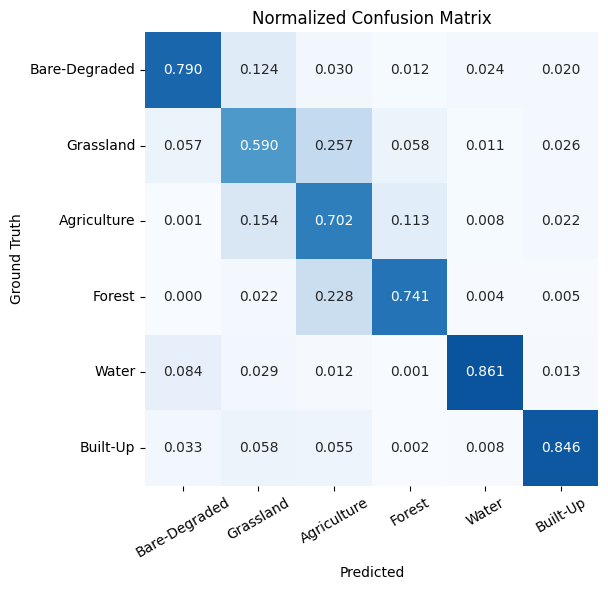

In [ ]:
import seaborn as sns

class_names = [
    'Bare-Degraded',
    'Grassland',
    'Agriculture',
    'Forest',
    'Water',
    'Built-Up',
    ]

# normalize confusion matrix
conf_mat_norm = conf_mat / (conf_mat.sum(axis=1, keepdims=True) + 1e-6)

# plot matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_mat_norm,
    annot=True,
    fmt='.3f',
    cmap='Blues',
    cbar=False,
    square=True,
    xticklabels=class_names,
    yticklabels=class_names,
    vmin=0.0,
    vmax=1.0,
)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.xticks(rotation=30)
#plt.yticks(rotation=10)

plt.tight_layout()
plt.show()

Here are some high-level confusion insights:
* overall matrix is diagonally strong, the model is not chaotic and errors are structured;
* most off-diagonal mass is concentrated in a few class pairs, not spread evenly;
* stable convergence and good calibration;
* confusions align with semantic proximity, not random noise;
* non-vegetation classes have lowest confusion;
* excellent Water and Built-Up performance.

Class-wise confusion patterns:
* **Class 0:** The main confusion is Grassland (12.4%). Interpretable transition class (sparse vegetation → bare soil).
* **Class 1:** Known semantic issue. Major leakage towards Agriculture (25.7%). Secondary leakage towards Bare-Degraded and Forest. Based on low recall (0.59), this class is under-detected relative to neighbors.
* **Class 2:** Another known semantic issue. Major leakage towards Grassland (15.4%) and Forest (11.3%). The model over-predicts Agriculture when unsure. Confirms bidirectional semantic ambiguity with class 1.
* **Class 3:** The main confusion is Agriculture (22.8%). There is almost no confusion with non-vegetation classes. Errors mostly due to crop texture similarity.
* **Class 4:** Very clean class and confident detection. Minor confusion with Bare-Degraded (8.4%).
* **Class 5:** Similar performance as Water. Strong diagonal dominance with robust spatial/structural cues. There is small leakage towards vegetation classes.

Overall, confusion is directional, not symmetric everywhere. Evaluation metrics are pulled down primarily by semantic overlap, not poor learning. Mobile-UNet is feature-consistent but label-ambiguous in vegetation subclasses. These errors reflect class definition limits, not architectural or training issues. Although Grassland and Agriculture are lowest in performance, both are not collapsing into background. This is a positive characteristic.

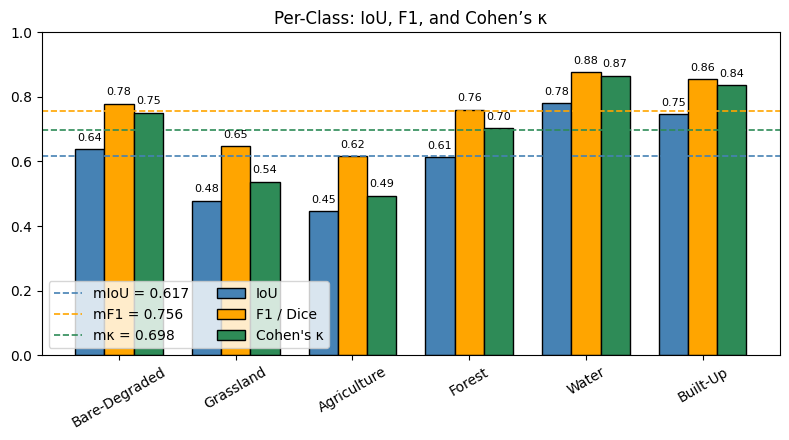

In [ ]:
# Iou + F1 + Kappa bar plot
class_names = [
    'Bare-Degraded',
    'Grassland',
    'Agriculture',
    'Forest',
    'Water',
    'Built-Up',
]

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(8, 4.5))

# IoU bars
bars_iou = plt.bar(
    x - width,
    iou_per_class,
    width,
    label='IoU',
    color='steelblue',
    edgecolor='black',
)

# F1 bars
bars_f1 = plt.bar(
    x,
    f1_per_class,
    width,
    label='F1 / Dice',
    color='orange',
    edgecolor='black',
)

# Kappa bars
bars_kappa = plt.bar(
    x + width,
    kappa_per_class,
    width,
    label="Cohen's κ",
    color='seagreen',
    edgecolor='black',
)

# mean reference lines
plt.axhline(
    y=iou_per_class.mean(),
    color='steelblue',
    linestyle='--',
    linewidth=1.2,
    label=f'mIoU = {iou_per_class.mean():.3f}',
)

plt.axhline(
    y=f1_per_class.mean(),
    color='orange',
    linestyle='--',
    linewidth=1.2,
    label=f'mF1 = {f1_per_class.mean():.3f}',
)

plt.axhline(
    y=kappa_per_class.mean(),
    color='seagreen',
    linestyle='--',
    linewidth=1.2,
    label=f'mκ = {kappa_per_class.mean():.3f}',
)

plt.title('Per-Class: IoU, F1, and Cohen’s κ')
plt.ylim(0, 1)
plt.xticks(x, class_names, rotation=30)
plt.legend(framealpha=0.8, ncol=2, loc='lower left')

# annotate bars
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.02,
            f'{h:.2f}',
            ha='center',
            va='bottom',
            fontsize=8,
        )

annotate_bars(bars_iou)
annotate_bars(bars_f1)
annotate_bars(bars_kappa)

plt.tight_layout()
plt.show()

Mobile-UNet performs excellent for classes with clear visual signatures (Water and Built-Up) but struggles to disentangle Grassland and Agriculture due to semantic overlap in the imagery, not model capacity, dataset noise, or training strategy. They look similar to background or other classes. Forest is decent but confused. Larger IoU-F1 gaps indicate more boundary or fragmentation issues. We can also notice that F1 is always greater than IoU by definition. Cohen's kappa drops harder for Grassland and Agriculture. This is due to high class overlap and similar prevalence. The model is consistently confused, not inconsistently wrong. Kappa interprets this as low semantic reliability.

Further gains for these classes likely require better label definitions, additional spectral/temporal cues, or class consolidation, rather than architectural or loss-level changes.

To sum up, the evaluation process shows that:
* the model is well-trained;
* the errors are structured and explainable;
* lower-performing classes are limited by semantic factors rather than geometric ones;
* the aggregate performance is solid for the Mobile-UNet architecture.

In [19]:
# perform predictions on first 200 images
pred = model.predict(X_val[:200], verbose=1, batch_size=16)

pred_classes = np.argmax(pred, axis=-1)
true_classes = np.argmax(y_val[:200], axis=-1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


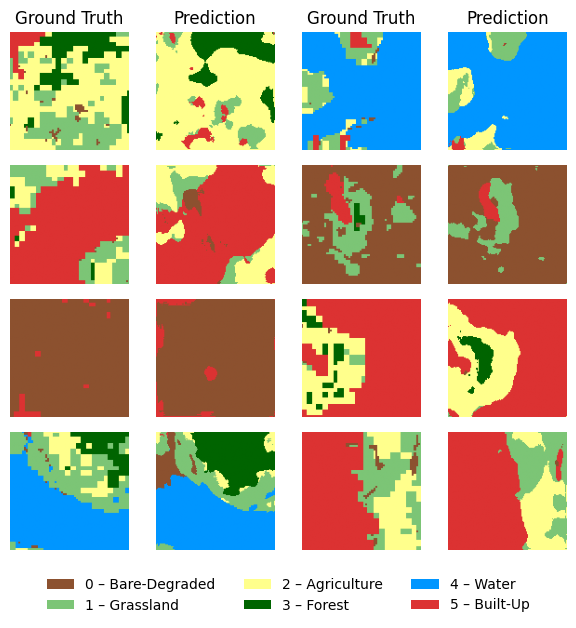

In [20]:
from matplotlib.patches import Patch

# selected indices
indices = [113, 56, 6, 82, 74, 115, 87, 15]

# plot figure
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
axs = axs.reshape(4, 4)

idx_iter = iter(indices)

for row in range(4):
    for pair in range(2):
        idx = next(idx_iter)

        col = pair * 2

        # ground truth labels
        axs[row, col].imshow(true_classes[idx], cmap=cus_cmap)
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title('Ground Truth')

        # predicted labels
        axs[row, col + 1].imshow(pred_classes[idx], cmap=cus_cmap)
        axs[row, col + 1].axis('off')
        if row == 0:
            axs[row, col + 1].set_title('Prediction')

# set legend at the bottom of the figure
legend_elements = [
    Patch(facecolor=CLASS_COLORS[i], label=f'{i} – {CLASS_NAMES[i]}')
    for i in CLASS_COLORS
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    )

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Example results from the Mobile-UNet model. From left to right: ground truth and predicted masks. Overall, the model produces accurate segmentation results.

### 9. Conclusions

Land use and land cover classification using remote sensing data is overall a challenging problem. This notebook presented an efficient deep learning model, named Mobile-UNet, for land cover classification, which is inspired by MobileNetV2 and U-Net. We evaluated our model on a public dataset (TALANDCOVER) in TIF format. Compared with U-Net, Mobile-UNet requires fewer parameters, and achieved high segmentation accuracy. In practical applications, the land cover in multiband imagery is mostly imbalanced and facing semantic issues, which makes the network difficult to train. In our case, vegetation classes exhibited significant similarities, leading to challenges in boundary delineation. To solve this problem, we utilize the improved loss function, focused on two most challenging classes, to make the model easier to train. The neural network's performance was evaluated with commonly used segmentation metrics. The model's architecture allowed us to observe the large learning capabilities on the data. However, improving dataset labeling or designing a more accurate loss function could further reduce semantic errors between Grassland and Agriculture classes.

**References:**
* D.A. Arrechea-Castillo, Y.T. Solano-Correa, J.F. Muñoz-Ordóñez, E.L. Pencue-Fierro, A. Figueroa-Casas, 2023, *Multiclass Land Use and Land Cover Classification of Andean Sub-Basins in Colombia with Sentinel-2 and Deep Learning*, [Full Text](https://doi.org/10.3390/rs15102521)
*  L.F. Gomez-Ossa, G. Sanchez-Torres, J. W. Branch-Bedoya, 2023, *Land Cover Classification in the Antioquia Region of the Tropical Andes Using NICFI Satellite Data Program Imagery and Semantic Segmentation Techniques*, [Full Text](https://doi.org/10.3390/data8120185)
* J. Jing, Z. Wang, M. Rätsch, H. Zhang, 2020, *Mobile-Unet: An Efficient Convolutional Neural Network for Fabric Defect Detection*, [Full Text](https://www.researchgate.net/publication/341749157_Mobile-Unet_An_efficient_convolutional_neural_network_for_fabric_defect_detection)
* NICFI Satellite Data Program: User Guide (2022), [Full Text](https://assets.planet.com/docs/NICFI_User_Guide_v4_EN.pdf)
* *Land Cover Classification with U-Net*, [Medium Webpage](https://baratam-tarunkumar.medium.com/land-cover-classification-with-u-net-aa618ea64a1b) (retrieved 08.02.2026)
* *Tropical Andes Land Cover Dataset (TALANDCOVER)*, 2023, [Open Dataset](https://zenodo.org/records/8219553) (retrieved 08.02.2026)